https://www.kaggle.com/ludovicocuoghi/twitter-sentiment-analysis-with-bert-roberta#RoBERTa-Sentiment-Analysis

In [13]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import emoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras

#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<Figure size 432x288 with 0 Axes>

In [14]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['-1', '1']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

In [15]:
df = pd.read_csv('snorkel.csv')
df_test = pd.read_excel('snorkel_test.xlsx')

In [16]:
df = df[['text','Labels1']]
df_test = df_test[['text','Labels1']]

In [17]:
  df['text_clean'] = df['text']
  df_test['text_clean'] =  df['text']

In [18]:
df['text_clean'].sample(10)

16224    अपनी दौलत के लिए और न शोहरत के लिए आओ मैदाँ मे...
632      india hows the jaish pakistan destroyed sir 😎🇮...
16440    to contribute for the families of crpf men kil...
10807    today’s covid19 report of uae qatar kuwait sau...
38378    please see to generateterawatts of clean energ...
10254    make your flying career “lit” this diwali diwa...
27197    pulwama में हमला हुआ ओर हमारे 42 जवान शहीद हुए...
35811    not to politicize or unsensitize the matter bu...
26776    so you china chinaliedpeopledied are now bribi...
25864    ku karenge bo twit bcz all are bikau ye log sa...
Name: text_clean, dtype: object

In [19]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

In [20]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

In [21]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 512


In [22]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    

In [23]:
df['token_lens'] = token_lens

In [24]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

,text,Labels1,text_clean,token_lens
23778,proud of you 🙏🙏🙏🙏 indianarmy indianarmyourprid...,1,proud of you 🙏🙏🙏🙏 indianarmy indianarmyourprid...,512
37180,मधु पूर्णिमा किश्वर जीमैं अपनी माँ बहन बेटी पत...,1,मधु पूर्णिमा किश्वर जीमैं अपनी माँ बहन बेटी पत...,436
11105,देश के पूर्व राष्ट्रपति प्रणब मुखर्जी के निधन ...,1,देश के पूर्व राष्ट्रपति प्रणब मुखर्जी के निधन ...,432
8360,राजस्थान के चुरू जिले में मल्टीस्पेशिलिटी हॉस्...,1,राजस्थान के चुरू जिले में मल्टीस्पेशिलिटी हॉस्...,430
6916,जम्मूकश्मीर में crpf के काफिले पर कायरतापूर्ण ...,1,जम्मूकश्मीर में crpf के काफिले पर कायरतापूर्ण ...,429
14664,pulwama आतंकी हमले में शहीद हुए हमारे देश के व...,1,pulwama आतंकी हमले में शहीद हुए हमारे देश के व...,428
4925,pulwama में हुए कायराना आतंकी हमले के खिलाफ शम...,1,pulwama में हुए कायराना आतंकी हमले के खिलाफ शम...,428
4409,जम्‍मूकश्‍मीर के पुलवामा में crpf के जवानों पर...,1,जम्‍मूकश्‍मीर के पुलवामा में crpf के जवानों पर...,428
1385,अरुणाचल प्रदेश में माँ भारती की रक्षा करते हुए...,1,अरुणाचल प्रदेश में माँ भारती की रक्षा करते हुए...,427
27702,शेरदिल जवानों के क़हर से बिलबिलाए नापाक गीदड़ो...,-1,शेरदिल जवानों के क़हर से बिलबिलाए नापाक गीदड़ो...,427


In [25]:
df = df.iloc[100:]
df.head()

,text,Labels1,text_clean,token_lens
31150,savekashmir लगातार पिछले ढाई घंटों से भारत में...,1,savekashmir लगातार पिछले ढाई घंटों से भारत में...,408
8972,कश्मीर हमारा है तो कश्मीर में रहने वाली हर बेट...,1,कश्मीर हमारा है तो कश्मीर में रहने वाली हर बेट...,408
1572,माँ का सुख गया पत्नी का सिंदूर गया नौनिहालों क...,1,माँ का सुख गया पत्नी का सिंदूर गया नौनिहालों क...,408
20871,लद्दाख़ में शहीद हुए बहादुर सिपाहियों को बतौर ...,1,लद्दाख़ में शहीद हुए बहादुर सिपाहियों को बतौर ...,408
32273,जम्मूकश्मीर में crpf के काफिले पर कायरतापूर्ण ...,1,जम्मूकश्मीर में crpf के काफिले पर कायरतापूर्ण ...,408


In [26]:
df = df.sample(frac=1).reset_index(drop=True)

In [27]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    
max_len=np.max(token_lens_test)

In [28]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 430


In [29]:
token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
   

In [30]:
df_test['token_lens'] = token_lens_test
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(10)

,text,Labels1,text_clean,token_lens
8360,savekashmir savekashmiri thanks a lot next mla...,1,राजस्थान के चुरू जिले में मल्टीस्पेशिलिटी हॉस्...,430
6916,à¤¸à¥‹à¤¸à¤¾à¤‡à¤Ÿà¥€ à¤•à¥€ à¤²à¤¿à¤«à¤¼à¥à¤...,-1,जम्मूकश्मीर में crpf के काफिले पर कायरतापूर्ण ...,429
4925,phulwamaterroristattack on our crpf soldiers i...,1,pulwama में हुए कायराना आतंकी हमले के खिलाफ शम...,428
4409,reflectionðŸ˜‰ lightupthesky light reflection ...,1,जम्‍मूकश्‍मीर के पुलवामा में crpf के जवानों पर...,428
1385,à¤œà¥€à¤µà¤¹à¤¤à¥à¤¯à¤¾à¤¬à¤‚à¤¦à¤•à¤°à¥‹ saa...,1,अरुणाचल प्रदेश में माँ भारती की रक्षा करते हुए...,427
2759,à¤à¤¯à¤° à¤«à¥‹à¤°à¥à¤¸ à¤•à¥€ à¤à¤• à¤¬à¤¡...,-1,केंद्रीयरिजर्वपुलिसबल crpf के स्थापना दिवस के ...,426
3120,lets be united nation first no compromise galw...,1,जिन्हे india की चिंता थी वो अपने और अपने परिवा...,423
6555,still we have lesser rates of covid19india tha...,1,भावपूर्ण श्रद्धांजली 🙏🏼 शहीद कर्नल संतोष बाबू ...,420
5403,2 countires 2 journalists but both are working...,-1,बड़ा दिल दिखाइए राहुल गाँधी जी और देश के सक्षम...,419
5691,where are you now india,-1,भारतीय अत्याचारों के 70 वर्षों के परिणामस्वरूप...,418


In [31]:
df_test= df_test.iloc[50:]
df_test.head()

,text,Labels1,text_clean,token_lens
7193,à¤œà¤®à¥à¤®à¥‚à¤•à¤¶à¥à¤®à¥€à¤° à¤•à¥‡ à¤ªà¥...,1,कश्मीर शांत हैजी जी बिल्कुल इंटरनेट बंद है मोब...,400
9174,3 the video of soldiers beating an terrorist i...,-1,चीन से खूनी संघर्ष में शहीद बिहार रेजीमेंट के ...,400
3939,morning beautiful view at mahabaleshwar tour p...,1,galwanvalley में चीन के साथ संघर्ष करते हुए दे...,399
969,upa chairperson smt sonia gandhis message on k...,1,बॉलीवुड अभिनेत्री ऋचा चड्ढा ने कॉमेडियन अग्रिम...,399
1624,if we cant see air do fish see water india pun...,-1,crpf की हवाईयात्रा की मांग गृह मंत्रालय ने ठुक...,399


In [32]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [33]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Labels1']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Label']);

In [34]:
train_os['Label'].value_counts()

-1    31996
 1    31996
Name: Label, dtype: int64

In [35]:
X = train_os['text_clean'].values
y = train_os['Label'].values

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [37]:
X_test = df_test['text_clean'].values
y_test = df_test['Labels1'].values

In [38]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [39]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [40]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 57592
VALIDATION DATA: 6400
TESTING DATA: 9783


In [41]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

In [42]:
token_lens = []

for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

408

In [43]:
MAX_LEN=410

In [44]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [45]:
train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

In [46]:
def create_model(bert_model, max_len=MAX_LEN):
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(2, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

In [47]:
roberta_model = TFRobertaModel.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')


Some layers from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment were not used when initializing TFRobertaModel: ['classifier']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [48]:
model = create_model(roberta_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 410)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 410)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 410,                                           

In [49]:
history_2 = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=3, batch_size=16)

Epoch 1/3
3600/3600 [==============================] - 3316s 916ms/step - loss: 0.4683 - categorical_accuracy: 0.7555 - val_loss: 0.4176 - val_categorical_accuracy: 0.7850
Epoch 2/3
3600/3600 [==============================] - 3294s 915ms/step - loss: 0.3543 - categorical_accuracy: 0.8245 - val_loss: 0.3512 - val_categorical_accuracy: 0.8278
Epoch 3/3
3600/3600 [==============================] - 3294s 915ms/step - loss: 0.2795 - categorical_accuracy: 0.8645 - val_loss: 0.3131 - val_categorical_accuracy: 0.8586


In [50]:
result_roberta = model.predict([test_input_ids,test_attention_masks])

In [51]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

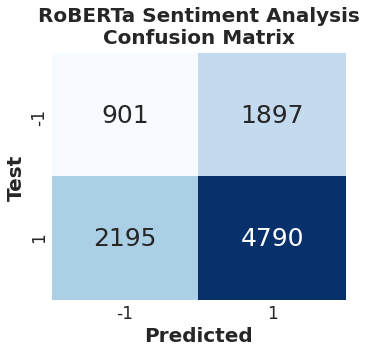

In [52]:
conf_matrix(y_test.argmax(1),y_pred_roberta.argmax(1),'RoBERTa Sentiment Analysis\nConfusion Matrix')

In [54]:
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta, target_names=['-1','1']))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

          -1       0.29      0.32      0.31      2798
           1       0.72      0.69      0.70      6985

   micro avg       0.58      0.58      0.58      9783
   macro avg       0.50      0.50      0.50      9783
weighted avg       0.59      0.58      0.59      9783
 samples avg       0.58      0.58      0.58      9783



In [ ]:
sns.countplot(x='Sentiment',data = df)